## Wrap environment

pygame 2.1.0 (SDL 2.0.16, Python 3.10.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


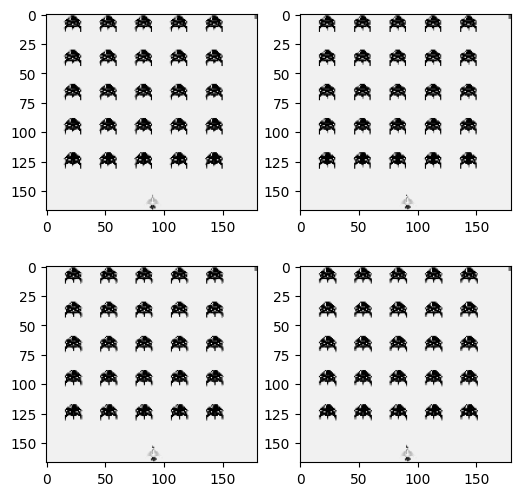

In [1]:
from utils import make_env

from matplotlib import pyplot as plt


num_stack = 4 # 10
# skipframe_div = 4

env = make_env(
    game_resolution=(720, 720), 
    num_stack=num_stack, 
)
obs = env.reset()

for _ in range(num_stack):
    action = env.action_space.sample()
    obs, *_ = env.step(action)

plt.figure(figsize=(6, 6)) # (30, 7)
for i in range(1, num_stack+1):
    plt.subplot(2, 2, i)
    plt.imshow(obs[..., i-1], cmap="gray")

## Check environment's FPS

In [2]:
import time


obs = env.reset()
done = False

frames = 0
start = time.time()
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)

    frames += 1

fps = frames / (time.time() - start)
fps

1184.3406139436347

## Dueling DDQN

In [3]:
action_spec = env.action_space
obs_spec = env.observation_space

action_spec, obs_spec

(Discrete(6), Box(0, 255, (167, 180, 4), uint8))

In [4]:
# conv_base = models.Sequential([
#     layers.Lambda(lambda input_batch: tf.cast(input_batch, dtype="float32") / 255.),
#     layers.Conv2D(32, 8, strides=4, padding="same", activation="relu"),
#     layers.Conv2D(64, 4, strides=2, padding="same", activation="relu"),
#     layers.Conv2D(64, 4, strides=2, padding="same", activation="relu"),
#     layers.Conv2D(128, 4, strides=2, padding="same", activation="relu"),
#     layers.Conv2D(128, 3, strides=1, padding="same", activation="relu"),
#     layers.Flatten()
# ])

# inputs = layers.Input(shape=obs_spec.shape[::-1]+(1,), dtype="uint8")
# x = layers.TimeDistributed(conv_base)(inputs)
# x = layers.GRU(512, dropout=0.4, return_sequences=True)(x)
# x = layers.GRU(128, dropout=0.4)(x)
# x = layers.Dense(128)(x)
# x = layers.Dropout(0.4)(x)
# state_values = layers.Dense(1)(x)
# raw_advantages = layers.Dense(action_spec.n)(x)
# advantages = raw_advantages - tf.reduce_max(raw_advantages, axis=1, keepdims=True)
# Q_values = state_values + advantages

# model = models.Model(inputs=inputs, outputs=Q_values)

# model.summary()

In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers, utils


# utils.set_random_seed(42)

inputs = layers.Input(shape=obs_spec.shape, dtype="uint8")
x = layers.Lambda(lambda input_batch: tf.cast(input_batch, dtype="float32") / 255.)(inputs)
x = layers.Conv2D(32, 8, strides=4, padding="same", activation="relu")(x)
x = layers.Conv2D(64, 4, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
state_values = layers.Dense(1)(x)
raw_advantages = layers.Dense(action_spec.n)(x)
advantages = raw_advantages - tf.reduce_max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages

model = models.Model(inputs=inputs, outputs=Q_values)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 167, 180, 4  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 167, 180, 4)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 42, 45, 32)   8224        ['lambda[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 21, 23, 64)   32832       ['conv2d[0][0]']             

In [6]:
target = models.clone_model(model)
target.set_weights(model.get_weights())

## Hyperparameters

In [7]:
from tensorflow.keras import optimizers, losses

# from utils import OnDiskReplayBuffer

from collections import deque


n_iterations = 500 # number of episodes to play and train
max_step = 10_000
train_interval = 4
truncate_in_shiphit = True
target_soft_update = True
target_update_interval = n_iterations * 0.15 * (0.5 if target_soft_update else 1)

gamma = 0.99 #discount factor
buffer_size = 65_000 # 43_000
fill_buffer_iters = 10

batch_size = 64
lr = 5e-6
optimizer = optimizers.Adam(learning_rate=lr)
loss_fn = losses.Huber()

# epsilon_fn = None
epsilon_fn = optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, 
    # decay_steps=(n_iterations-1) // train_interval,
    decay_steps=(n_iterations-1),
    end_learning_rate=0.01
)

replay_buffer = deque(maxlen=buffer_size)
# replay_buffer = OnDiskReplayBuffer(buffer_size)


params = {
    "iteration": n_iterations,
    "n_step": max_step,
    "batch_size": batch_size,
    "gamma": gamma,
    "warmup": fill_buffer_iters,
    "train_interval": train_interval,
    "target_update_interval": target_update_interval,
    "soft_update": target_soft_update,
    "truncate_in_shiphit": truncate_in_shiphit,
    "epsilon_fn": epsilon_fn
}

## Training Agent

In [9]:

from utils import DQNAgent


agent = DQNAgent(
    env=env, model=model, target=target, 
    optimizer=optimizer, loss_fn=loss_fn, 
    replay_buffer=replay_buffer
)

rewards, total_loss = agent.training_loop(**params)

model.save(f"models/Alien Invasion DQN ({n_iterations} iters).h5")

Episode: 499, Steps: 2460, FPS: 122, Reward:-534.1, Epsilon: 0.0100, Loss: 0.2009737491607666WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


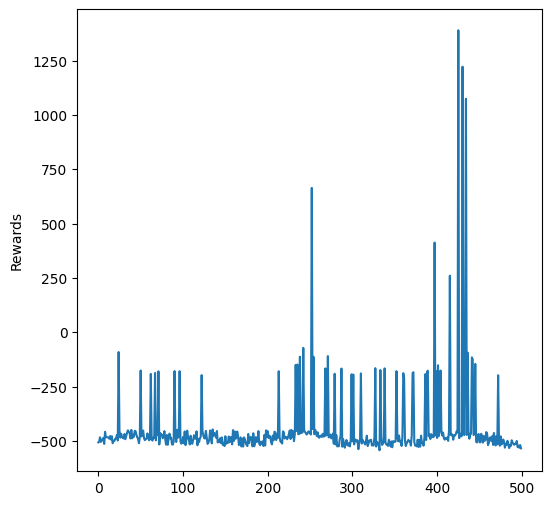

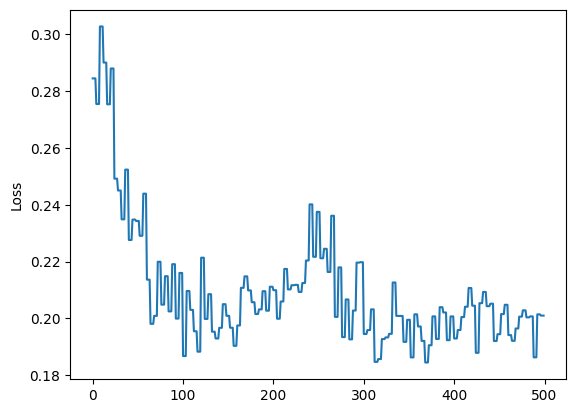

In [10]:
plt.figure(figsize=(6, 6))

plt.plot(range(len(rewards)), rewards)
plt.ylabel("Rewards")
plt.show()

plt.plot(range(len(total_loss)), total_loss, label="Loss")
plt.ylabel("Loss")
plt.show()

In [11]:
# env = make_env()
obs = env.reset()
rewards = 0
done = False

frames = []
start = time.time()
while not done:
    action = agent.epsilon_greedy_policy(obs, 0.01)
    obs, reward, done, info = env.step(action)

    rewards += reward
    print("\r{}, {}".format(rewards, reward), end="")

    frames.append(obs[..., -1])

fps = len(frames) / (time.time() - start)
print(f"\nFPS: {fps}")

-1531.3660000001219, -0.0285
FPS: 131.88606070799918


In [12]:
import PIL

import os


image_path = os.path.join("rl videos", f"alieninvasion_dqn_{n_iterations}_iters.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)

In [15]:
model.load_weights("models/DQN_ep#425_eps#0.1568_rw#1389.3.h5")

# env = make_env()
obs = env.reset()
rewards = 0
done = False

frames = []
start = time.time()
while not done:
    action = agent.epsilon_greedy_policy(obs, 0.1568)
    obs, reward, done, info = env.step(action)

    rewards += reward
    print("\r{}, {}".format(rewards, reward), end="")

    frames.append(obs[..., -1])

fps = len(frames) / (time.time() - start)
print(f"\nFPS: {fps}")

1645.2280000003002, -0.02499999999999
FPS: 144.34786986818656


In [23]:
image_path = os.path.join("rl videos", f"alieninvasion_dqn_{n_iterations}_iters_ep#425_eps#0.1568.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=0.1,
                     loop=0)

In [29]:
image_path = os.path.join("rl videos", f"alieninvasion_dqn_{n_iterations}_iters_ep#425_eps#0.1568_B.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1::100],
                     save_all=True,
                     duration=0.1,
                     loop=0)

In [31]:
len(frames)

24272